# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamesnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading dataset

In [2]:
root = os.getcwd()
#yelp polarity has 2 labels, 
#yelp dataset has 5 labels, they have the same text content
train_datapath = os.path.join(root, 'dataset', 'yelp_polarity', 'train.csv') 
test_datapath = os.path.join(root,  'dataset', 'yelp_polarity', 'test.csv') 

assert os.path.exists(train_datapath),  f"train dataset path {train_datapath} not found"
assert os.path.exists(test_datapath),   f"test dataset path {test_datapath} not found"

sample_size = 0.1

In [3]:
train_df = pd.read_csv(train_datapath, names = ["review","text"])
train_df = train_df.sample(frac = sample_size)
print(train_df.shape)
train_df.reset_index(inplace=True, drop = True)
train_df.head()

(56000, 2)


,review,text
0,1,When I'm hungry for Italian...\n\n... I see th...
1,1,"We had the all-you-can eat experience, and it ..."
2,1,The first time I attended this bar I requested...
3,2,Great spot in downtown Mesa. Every time I come...
4,1,I've been going to Manuel's with my family for...


# Cleaning

In [4]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [5]:
eda_df = train_df.copy()
eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
eda_df.head()

,review,text
0,1,hungry italian see martorano billboard lose ap...
1,1,eat experience complete waste money steep pers...
2,1,first time attended bar requested tab opened s...
3,2,great spot downtown mesa every time come order...
4,1,going manuel family years good chips salsa def...


# A little EDA

In [6]:
# wordcloud of common words
freq = collections.Counter()

for row in eda_df.iterrows():
    label, text = row[1]
    freq.update(text.split())

print('most frequent words')
print(freq.most_common(10))


most frequent words
[('food', 33226), ('place', 32202), ('good', 30686), ('would', 28263), ('like', 26415), ('get', 23613), ('one', 23248), ('time', 21692), ('service', 21103), ('great', 21057)]


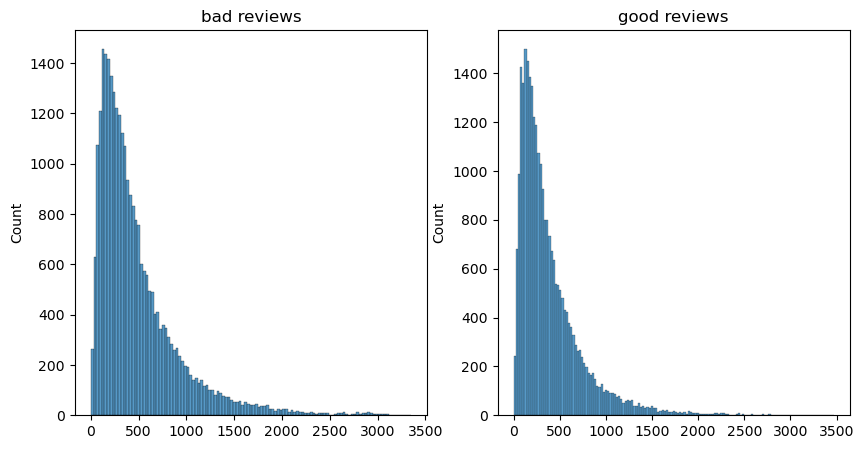

In [7]:
bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
sns.histplot(x = bad_reviews, label = 'bad reviews', ax = ax1)
ax1.set_title('bad reviews')
sns.histplot(x = good_reviews, label = 'good reviews', ax = ax2)
ax2.set_title('good reviews')
plt.show()

review
1    28183
2    27817
Name: count, dtype: int64


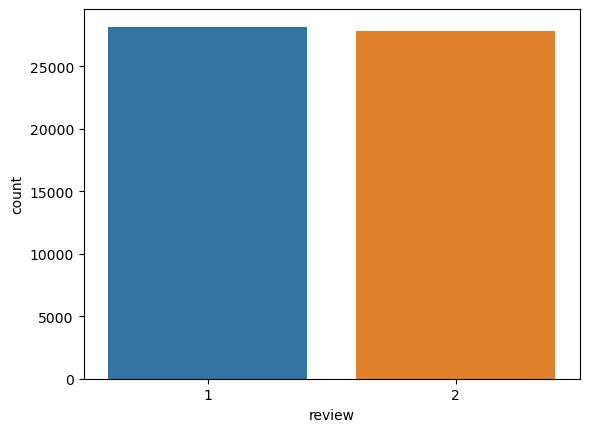

In [8]:
print(eda_df['review'].value_counts())
sns.countplot(x = eda_df['review'])
plt.show()

# Prepare data

In [9]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 256):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 5, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor([0 if label == 1 else 1 for label in labels])
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id

In [10]:
X_array = train_df['text'].apply(lambda s: clean_text(s)).values
y_array = train_df['review'].values

(train_tokens, train_ids, train_y, train_lengths), vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

100%|██████████| 56000/56000 [00:01<00:00, 49599.04it/s]


vocab len =  22373


100%|██████████| 56000/56000 [00:00<00:00, 86704.63it/s]


ids shape =  torch.Size([56000, 256])
y shape =  torch.Size([56000])
lengths shape =  torch.Size([56000])


In [11]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=0
tokens=['hungry', 'italian', 'see', 'martorano', 'billboard', 'lose', 'appetite']
length=7
ids=tensor([  597,   549,    71, 14855, 14507,  2000,  2539,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    

In [18]:
class AmazonReviewDataset(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]

NUM_CLASSES = len(set(list(train_y.tolist())))

train_dataset = AmazonReviewDataset(train_ids[:100], train_y[:100], train_lengths[:100])

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])


BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))

num class =  2
train dataset len =  80
train dataloader len =  1
val dataset len =  20
val dataloader len =  1


# Test Model

In [13]:

class LSTM(nn.Module):
    def __init__(
        self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,
        bidirectional,dropout_rate,pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,bidirectional=bidirectional,dropout=dropout_rate,batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if "bias" in name:
                    nn.init.zeros_(param)
                elif "weight" in name:
                    nn.init.orthogonal_(param)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction

In [14]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def tune(model, optimizer, criterion, epochs = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"The model has {model.count_parameters()} trainable parameters")

    model = model.to(device)
    criterion = criterion.to(device)
    best_valid_loss = float("inf")
    history = []

    history = collections.defaultdict(list)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        # test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        # history["test_losses"].append(test_loss)
        # history["test_accs"].append(test_acc)
        # if test_loss < best_valid_loss:
        #     best_valid_loss = test_loss
        #     torch.save(model, f"lstm.checkpoint.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        # print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

    return history

def plot(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    # sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    # sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

# Pretrained embedding

In [16]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

.vector_cache/glove.840B.300d.zip: 2.18GB [35:49, 1.01MB/s]                               
100%|█████████▉| 2196016/2196017 [02:12<00:00, 16529.17it/s]


# Test run LSTM

In [20]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim  ,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 2)

plot(history)

output dim =  2
The model has 10322702 trainable parameters


evaluating...: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


epoch: 0
train_loss: 0.698, train_acc: 0.488
val_loss: 0.688, valid_acc: 0.700


evaluating...: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


epoch: 1
train_loss: 0.687, train_acc: 0.587
val_loss: 0.681, valid_acc: 0.750


training...:   0%|          | 0/1 [00:05<?, ?it/s]


KeyboardInterrupt: 